In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from google.colab import drive
from skimage.transform import resize
import random
import tarfile
import os

drive.mount('/content/drive')
file_dir = "/content/drive/My Drive/facades.tar.gz"
tarfile.open(file_dir).extractall()

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Thu Feb  4 10:26:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def rp(mu, lv):
    return mu + torch.exp(0.5 * lv) * torch.randn_like(mu)

def kld_normals(mu, lv):
    kld = - lv + torch.exp(lv) + (mu**2) - 1.0
    return 0.5 * kld

In [ ]:
class ImageFolder(Dataset):
    def __init__(self, dir):
        self.dir = dir
        self.file_list = os.listdir(self.dir)
        


    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = plt.imread(os.path.join(self.dir, self.file_list[idx]))
        real_B, real_A = np.split(img, 2, axis=1)
        base_image_size = np.random.randint(257, 286)
        real_A = resize(real_A, (base_image_size, base_image_size))
        real_B = resize(real_B, (base_image_size, base_image_size))
        lu_x = np.random.randint(0, base_image_size - 256)
        lu_y = np.random.randint(0, base_image_size - 256)
        real_A = real_A[lu_y:lu_y + 256, lu_x:lu_x + 256, :]
        real_B = real_B[lu_y:lu_y + 256, lu_x:lu_x + 256, :]
        return real_A, real_B



In [ ]:
def bn_act(conv, bn, act):
    sequential = [conv]
    if bn: sequential += [nn.BatchNorm2d(conv.out_channels, momentum=0.05)]
    sequential += [act]
    return nn.Sequential(*sequential)

class Generator(nn.Module):
    def __init__(self, z_size):
        super().__init__()
        self.enc = nn.ModuleList([
            bn_act(nn.Conv2d(3 + z_size,   64,  4, stride=2, padding=1, padding_mode='reflect', bias=True), False, nn.LeakyReLU(0.2)),
            bn_act(nn.Conv2d(64,  128, 4, stride=2, padding=1, padding_mode='reflect', bias=False), True, nn.LeakyReLU(0.2)),
            bn_act(nn.Conv2d(128, 256, 4, stride=2, padding=1, padding_mode='reflect', bias=False), True, nn.LeakyReLU(0.2)),
            bn_act(nn.Conv2d(256, 512, 4, stride=2, padding=1, padding_mode='reflect', bias=False), True, nn.LeakyReLU(0.2)),
            bn_act(nn.Conv2d(512, 512, 4, stride=2, padding=1, padding_mode='reflect', bias=False), True, nn.LeakyReLU(0.2)),
            bn_act(nn.Conv2d(512, 512, 4, stride=2, padding=1, padding_mode='reflect', bias=False), True, nn.LeakyReLU(0.2)),
            bn_act(nn.Conv2d(512, 512, 4, stride=2, padding=1, padding_mode='reflect', bias=False), True, nn.LeakyReLU(0.2)),
            bn_act(nn.Conv2d(512, 512, 4, stride=2, padding=1, padding_mode='reflect', bias=False), True, nn.LeakyReLU(0.2))
        ])

        self.bottleneck = nn.Sequential(nn.Dropout2d(0.1), bn_act(nn.Conv2d(512, 512, 1, bias=False), True, nn.LeakyReLU(0.2)), nn.Dropout2d(0.1))

        self.dropouts = nn.ModuleList([nn.Dropout2d(0.2) for _ in range(3)])    
        
        self.dec = nn.ModuleList([
            bn_act(nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1, bias=False), True, nn.ELU()),
            bn_act(nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1, bias=False), True, nn.ELU()),
            bn_act(nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1, bias=False), True, nn.ELU()),
            bn_act(nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1, bias=False), True, nn.ELU()),
            bn_act(nn.ConvTranspose2d(1024, 256, 4, stride=2, padding=1, bias=False), True, nn.ELU()),
            bn_act(nn.ConvTranspose2d(512,  128, 4, stride=2, padding=1, bias=False), True, nn.ELU()),
            bn_act(nn.ConvTranspose2d(256,   64, 4, stride=2, padding=1, bias=False), True, nn.ELU()),
            bn_act(nn.ConvTranspose2d(128,  128, 4, stride=2, padding=1, bias=False), True, nn.ELU()),
        ])

        self.toRGB = nn.Sequential(nn.Conv2d(128, 3, 3, stride=1, padding=1, bias=True), nn.Tanh())
        

    def forward(self, x, z):

        z = z.view(z.size(0), -1, 1, 1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, z], dim=1) 

        out = []
        for enc in self.enc:
            x = enc(x)
            out.append(x)        
        out.reverse()

        x = self.bottleneck(x)
        
        for i, dec in enumerate(self.dec):
            u_res = out[i]
            if i < 3: u_res = self.dropouts[i](u_res)
            x = dec(torch.cat([x, u_res], dim=1))
        return self.toRGB(x)


In [ ]:
class E_NLayers(nn.Module):
    def __init__(self, input_nc, output_nc=1, ndf=64, n_layers=3):
        super(E_NLayers, self).__init__()

        kw, padw = 4, 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw,
                              stride=2, padding=padw), nn.ELU()]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 4)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw)]

            sequence += [nn.BatchNorm2d(ndf * nf_mult)]
            sequence += [nn.ELU()]

        sequence += [nn.AvgPool2d(8)]
        self.conv = nn.Sequential(*sequence)
        self.fc = nn.Sequential(*[nn.Linear(ndf * nf_mult, output_nc)])
        self.fcVar = nn.Sequential(*[nn.Linear(ndf * nf_mult, output_nc)])

    def forward(self, x):
        x_conv = self.conv(x)
        conv_flat = x_conv.view(x.size(0), -1)
        output = self.fc(conv_flat)
        outputVar = self.fcVar(conv_flat)
        return output, outputVar




class D_NLayersMulti(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, num_D=1):
        super(D_NLayersMulti, self).__init__()

        self.num_D = num_D

        if num_D == 1:
            layers = self.get_layers(input_nc, ndf, n_layers)
            self.model = nn.Sequential(*layers)
        else:
            layers = self.get_layers(input_nc, ndf, n_layers)
            self.add_module("model_0", nn.Sequential(*layers))
            self.down = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)
            for i in range(1, num_D):
                ndf_i = int(round(ndf / (2**i)))
                layers = self.get_layers(input_nc, ndf_i, n_layers)
                self.add_module("model_%d" % i, nn.Sequential(*layers))

    def get_layers(self, input_nc, ndf=64, n_layers=3):
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw),
                nn.BatchNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw),
            nn.BatchNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        return sequence

    def forward(self, input):
        if self.num_D == 1:
            return self.model(input)
        result = []
        down = input
        for i in range(self.num_D):
            model = getattr(self, "model_%d" % i)

            out_i = model(down)

            result.append(out_i.flatten(1, -1))
            if i != self.num_D - 1:
                down = self.down(down)
        return torch.cat(result, dim=1)


In [ ]:
netD1 = D_NLayersMulti(input_nc=3, ndf=64, n_layers=3, num_D=2).to(device)
netD2 = D_NLayersMulti(input_nc=3, ndf=64, n_layers=3, num_D=2).to(device)

netG = Generator(8).to(device)
netE = E_NLayers(3, 8, 64, 5).to(device)


In [ ]:
mbsz = 4
dataset = ImageFolder('./facades/train')
loader = DataLoader(dataset=dataset, batch_size=mbsz, shuffle=True, drop_last=True)


to_batch_format = lambda x: x.permute(0, 3, 1, 2).float().to(device)
normalize = lambda x: (x - 0.5) * 2.0
normalize_inv = lambda x: x / 2 + 0.5

In [ ]:

D1_solver = torch.optim.Adam(netD1.parameters(), lr=1e-4, betas=(0.5, 0.999))
D2_solver = torch.optim.Adam(netD2.parameters(), lr=1e-4, betas=(0.5, 0.999))

G_solver = torch.optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.999))
E_solver = torch.optim.Adam(netE.parameters(), lr=1e-4, betas=(0.5, 0.999))

w_L1 = 1.0
w_adv1 = 1.0
w_adv2 = 1.0 
w_z = 0.5
w_kl = 0.01

train_L1loss = []
train_D_true = []
train_D_fake = []

In [ ]:

for epoch in range(20):
    train_L1loss.append(0.0)
    train_D_true.append(0.0)
    train_D_fake.append(0.0)
    for (real_A, real_B) in loader:

        half_size = mbsz // 2

        real_B = normalize(to_batch_format(real_B))
        real_A = normalize(to_batch_format(real_A))

        # A1, B1 for encoded; A2, B2 for random
        real_A_encoded = real_A[0:half_size]
        real_B_encoded = real_B[0:half_size]
        real_A_random = real_A[half_size:]
        real_B_random = real_B[half_size:]



        
        E_solver.zero_grad()
        G_solver.zero_grad()

        mu, logvar = netE(real_B_encoded)
        z_encoded = rp(mu, logvar)
        z_sampled = torch.randn_like(mu)

        fake_B_encoded = netG(real_A_encoded, z_encoded)
        # generate fake_B_random
        fake_B_sampled = netG(real_A_random, z_sampled)


        p_fake_encoded = netD1(fake_B_encoded)
        g_fake_adv_encoded = F.mse_loss(p_fake_encoded, torch.zeros_like(p_fake_encoded))

        p_fake_sampled = netD2(fake_B_sampled)
        g_fake_adv_sampled = F.mse_loss(p_fake_sampled, torch.zeros_like(p_fake_sampled))

        x_recon = F.l1_loss(fake_B_encoded, real_B_encoded)
        kl_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean(dim=0).sum()
        

   
        loss_GE = w_adv1 * g_fake_adv_encoded + w_adv2 * g_fake_adv_sampled + 20.0 * w_L1 * x_recon + w_kl * (5.0) * kl_loss

        loss_GE.backward(retain_graph=True)

        E_solver.step()

        mu_pred, lv_pred = netE(fake_B_sampled)
        z_recon =  F.l1_loss(mu_pred, z_sampled)
        (w_z * 16.0 * z_recon).backward()

        G_solver.step()


        D1_solver.zero_grad()
        D2_solver.zero_grad()


        pred_fake1 = netD1(fake_B_encoded.detach())
        pred_real1 = netD1(real_B_encoded)
        pred_fake2 = netD2(fake_B_sampled.detach())
        pred_real2 = netD2(real_B_random)

        # ZERO = torch.zeros_like(pred_fake1)
        ONE = torch.ones_like(pred_fake1)

        loss_D = F.mse_loss(pred_fake1, -ONE) + F.mse_loss(pred_fake2, -ONE) + F.mse_loss(pred_real1, ONE) + F.mse_loss(pred_real2, ONE)
        loss_D.backward()

        D1_solver.step()
        D2_solver.step()
        
        


        train_L1loss[-1] += x_recon.item()
        train_D_true[-1] += pred_fake1.mean().item()   
        train_D_fake[-1] += pred_real1.mean().item()



    train_L1loss[-1] /= len(loader) 
    train_D_true[-1] /= len(loader)
    train_D_fake[-1] /= len(loader)
    print(train_L1loss[-1], train_D_true[-1], train_D_fake[-1])


0.28282120794057847 -0.7078488267865032 0.7047724164929241
0.28590106055140496 -0.6861768445372581 0.6922839396446944
0.284314573854208 -0.7151664771139622 0.7124483294039965
0.2899463452398777 -0.7095386380329728 0.7042940036932123
0.2821464270353317 -0.7080888747051358 0.7135670803114772
0.2812697757780552 -0.723004079759121 0.7080984176602214
0.27691916123032567 -0.7068227017391473 0.707091608629562
0.2751537300646305 -0.7044539861381054 0.7149505003727973
0.27233704894781113 -0.7097776786983013 0.7060296431928873
0.2785771889984608 -0.6786982268840075 0.676913928873837
0.2784761452674866 -0.7020936766266823 0.7068194473860785
0.2700092972815037 -0.7029694358631968 0.7010562360845506
0.26693217739462854 -0.6860802026093006 0.6819635542156175
0.2742855344712734 -0.6793029911443591 0.67716431833338
0.2732266466319561 -0.6845921039301902 0.6848291247710585
0.2723894901573658 -0.7060577452927828 0.7137960786744952
0.27514362677931786 -0.703318748138845 0.6926001190021635
0.2745139768719

In [ ]:
testdataset = ImageFolder('./facades/test')

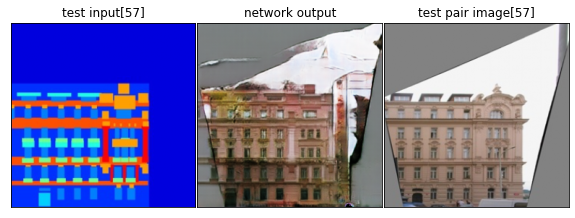

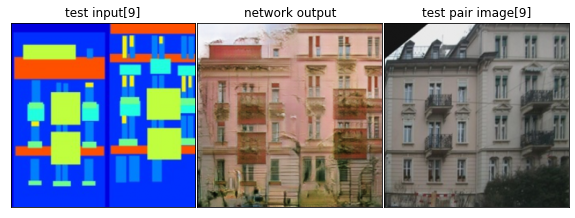

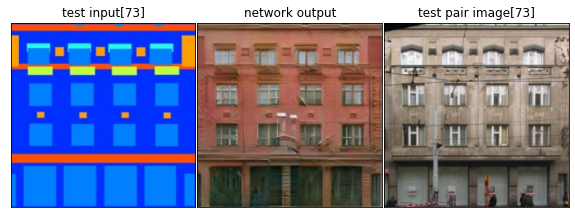

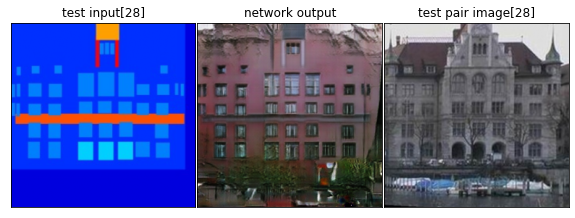

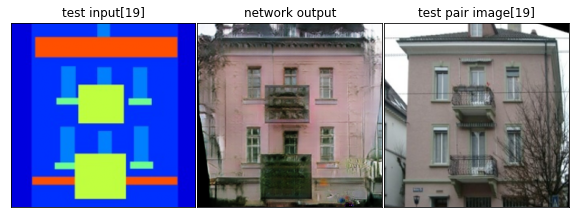

In [ ]:
def validation2(idx=None):
    if idx == None:
        idx = np.random.randint(0, len(testdataset) - 1)

    real_A, real_B = testdataset.__getitem__(idx)

    





    netG.eval()
    x = normalize(to_batch_format(torch.Tensor(real_A).unsqueeze(0)))
    z = torch.randn(1, 8).to(device)
    fake_B = netG(x, z)

    netG.train()
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
    ax.set_title('test input[' + str(idx) + ']')
    ax.imshow(real_A )
    ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    ax.set_title('network output')
    ax.imshow(normalize_inv(fake_B.squeeze(0).cpu().detach().permute(1, 2, 0)))
    ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    ax.set_title('test pair image[' + str(idx) + ']')
    ax.imshow(real_B)
    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    plt.show()

    

validation2()
validation2()
validation2()
validation2()
validation2()


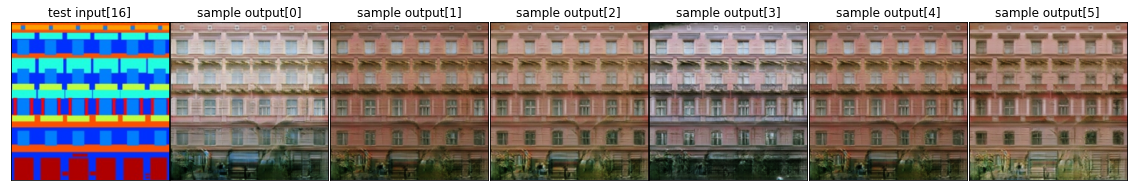

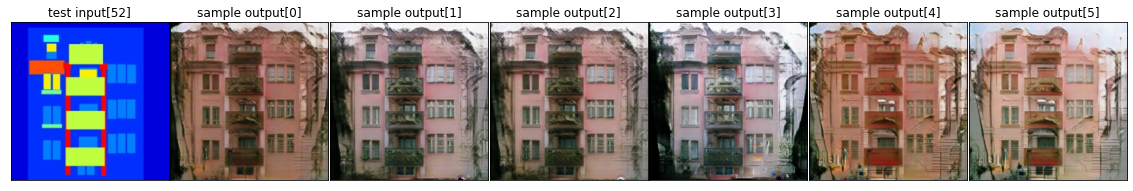

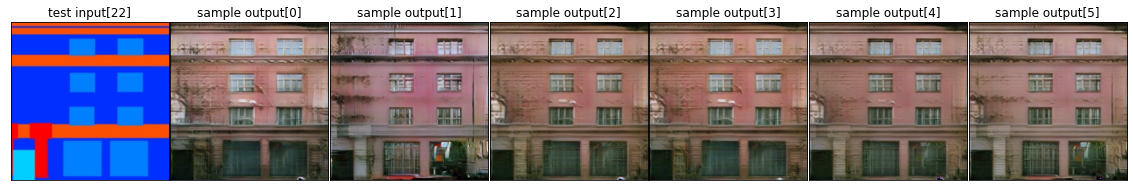

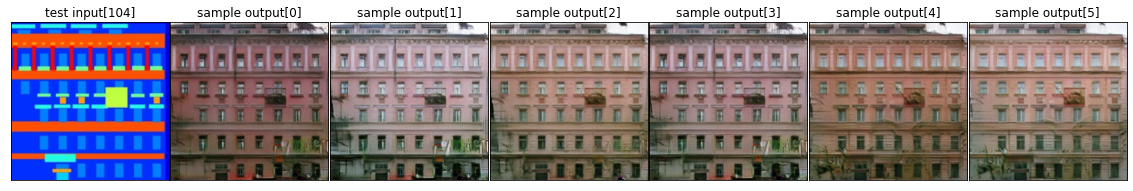

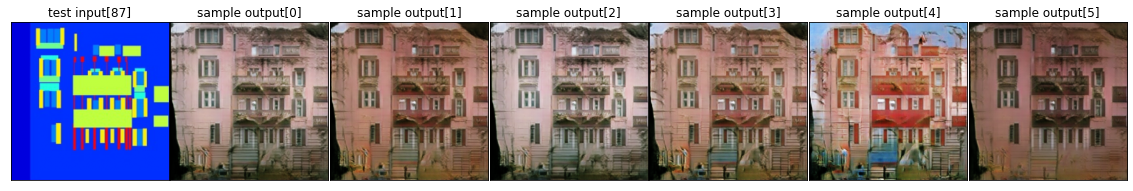

In [ ]:
def latent(idx=None):
    if idx == None:
        idx = np.random.randint(0, len(testdataset) - 1)

    real_A, real_B = testdataset.__getitem__(idx)

    

    netG.eval()

    num_sample = 6
    x = normalize(to_batch_format(torch.Tensor(real_A).unsqueeze(0).expand(num_sample, -1, -1, -1)))
    z = torch.randn(num_sample, 8).to(device)
    fake_B = netG(x, z)

    netG.train()
    fig = plt.figure(figsize=(20, 5))

    ax = fig.add_subplot(1, 1 + num_sample, 1, xticks=[], yticks=[])
    ax.set_title('test input[' + str(idx) + ']')
    ax.imshow(real_A)

    for i in range(num_sample):
        ax = fig.add_subplot(1, 1 + num_sample, i + 2, xticks=[], yticks=[])
        ax.set_title('sample output[' + str(i) +  ']')
        ax.imshow(normalize_inv(fake_B[i].squeeze(0).cpu().detach().permute(1, 2, 0)))


    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    plt.show()

    

latent()
latent()
latent()
latent()
latent()
